# Import

In [3]:
from joblib import load, dump
import numpy as np
import pandas as pd

### Reading Datasets

In [4]:
X_train_fft = load('../../BEST SET/X_train_fft.joblib')
X_test_fft = load('../../BEST SET/X_test_fft.joblib')

X_train_raw = load('../../BEST SET/raw_X_train.joblib')
X_test_raw = load('../../BEST SET/raw_X_test.joblib')

y_train = load('../../BEST SET/y_train.joblib')
y_test = load('../../BEST SET/y_test.joblib')

## Spectral Subtr

In [5]:
def spectral_subtraction(earthquake_data_fft, avg_noise_spectrum):
        cleaned_data_fft = earthquake_data_fft - avg_noise_spectrum
        return cleaned_data_fft

def subt(X, y):    
    neg = X[np.where(y == 0)[0]]
    avg_noise_spectrum = np.mean(neg, axis=0)
    spec_subt = np.array([spectral_subtraction(sample, avg_noise_spectrum) for sample in X])
    return spec_subt

In [7]:
X_train_subt = subt(X_train_fft, y_train)
X_test_subt = subt(X_test_fft, y_test)

dump(X_train_subt, '../BEST SET/X_train_subt.joblib')
dump(X_test_subt, '../BEST SET/X_test_subt.joblib')

['../BEST SET/X_test_subt.joblib']

Did not use below but considered it.

In [9]:
def ran_subt(X, y):
    neg = X[np.where(y == 0)[0]]    
    spec_subt = np.zeros_like(X) 
    for i, sample in enumerate(X):
        random_noise_sample = neg[np.random.randint(0, len(neg))]  
        spec_subt[i] = spectral_subtraction(sample, random_noise_sample) 

    return spec_subt

# Spectral Noise Addition

In [8]:
def spectral_addition(earthquake_data_fft, avg_noise_spectrum):
        cleaned_data_fft = earthquake_data_fft + avg_noise_spectrum
        return cleaned_data_fft

def noise_add(X, y):
    neg = X[np.where(y == 0)[0]]

    avg_noise_spectrum = np.mean(neg, axis=0)    

    noise_add = np.array([spectral_addition(sample, avg_noise_spectrum) for sample in X])
    return noise_add

In [9]:
X_train_add = subt(X_train_fft, y_train)
X_test_add = subt(X_test_fft, y_test)

dump(X_train_add, '../BEST SET/X_train_add.joblib')
dump(X_test_add, '../BEST SET/X_test_add.joblib')

['../BEST SET/X_test_add.joblib']

# Keep Only A OR A+B Quality

In [10]:
train_details = load('../BEST SET/train_details.joblib')
train_details_pos = pd.DataFrame(train_details['Positive'])

## Keep Only A

In [13]:
#get yes data
X_train_pos_only_A = X_train_fft[np.where(train_details_pos[3] == 'A')]
y_train_pos_only_A = y_train[np.where(train_details_pos[3] == 'A')]

#get balanced Nos
sh = int(y_train.shape[0]/2)
X_No = X_train_fft[sh: sh+X_train_pos_only_A.shape[0]]
y_No = y_train[sh:sh+X_train_pos_only_A.shape[0]]
train_details = load('../BEST SET/train_details.joblib')

train_details_pos = pd.DataFrame(train_details['Positive'])

X_train_only_A = np.append(X_train_pos_only_A, X_No, axis=0)
y_train_only_A = np.append(y_train_pos_only_A, y_No, axis=0)

dump(X_train_only_A, '../BEST SET/X_train_only_A.joblib')
dump(y_train_only_A, '../BEST SET/y_train_only_A.joblib')

['../BEST SET/y_train_only_A.joblib']

## Keep Only A + B

In [15]:
#get yes data
X_train_pos_A_and_B = X_train_fft[np.where(train_details_pos[3].isin(['A', 'B']))]
y_train_A_and_B = y_train[np.where(train_details_pos[3].isin(['A', 'B']))]

#get balanced Nos
sh = int(y_train.shape[0]/2)
X_No = X_train_fft[sh: sh+X_train_pos_A_and_B.shape[0]]
y_No = y_train[sh: sh+X_train_pos_A_and_B.shape[0]]

X_train_A_and_B = np.append(X_train_pos_A_and_B, X_No, axis=0)
y_train_A_and_B = np.append(y_train_A_and_B, y_No, axis=0)

dump(X_train_A_and_B, '../BEST SET/X_train_A_and_B.joblib')
dump(y_train_A_and_B, '../BEST SET/y_train_A_and_B.joblib')

['../BEST SET/y_train_A_and_B.joblib']

# Filtering

### Highpass 2.5Hz

In [116]:
import numpy as np
import obspy
from joblib import load, dump

In [117]:
def make_traces(dataset):
    streams = []
    for sample in dataset:
        st = obspy.Stream()
        for i, component_data in enumerate(sample):
            tr = obspy.Trace(data=component_data)
            tr.stats.channel = ['HHE', 'HHN', 'HHZ'][i]
            tr.stats.delta = 1/80 
            st += tr
        streams.append(st)
    return streams

In [118]:
def filter_streams(streams):
    for x in streams:
        x.filter('highpass', freq=2.5)

In [119]:
def apply_fft(data):
    fft_data = np.fft.fft(data)
    return np.abs(fft_data)

In [ ]:
X_train_raw = load('../../BEST SET/raw_X_train.joblib')
X_test_raw = load('../../BEST SET/raw_X_test.joblib')

train_streams = make_traces(X_train_raw)
test_streams = make_traces(X_test_raw)

filter_streams(train_streams)
filter_streams(test_streams)

X_train_fft = [apply_fft(sample) for sample in train_streams]
X_test_fft = [apply_fft(sample) for sample in test_streams]

dump(np.array(X_train_fft), '../../BEST SET/X_train_filtered.joblib')
dump(np.array(X_test_fft), '../../BEST SET/X_test_filtered.joblib')

# Printing per Quality

In [176]:
import pandas as pd
events = pd.read_csv('../../Data/allevents.csv')

In [166]:
def plot(year, day, pTime):
    HHE = path+f"{year}/MN/WDD/HHE.D/MN.WDD..HHE.D.{year}.{str(day).zfill(3)}"
    HHN = path+f"{year}/MN/WDD/HHN.D/MN.WDD..HHN.D.{year}.{str(day).zfill(3)}"
    HHZ = path+f"{year}/MN/WDD/HHZ.D/MN.WDD..HHZ.D.{year}.{str(day).zfill(3)}"
    st = obspy.read(HHE)
    st += obspy.read(HHN)
    st += obspy.read(HHZ)
    pTime = obspy.UTCDateTime(pTime)
    st = st.slice(starttime=pTime-5, endtime=pTime+90)
    st.plot()

In [221]:
def plot_filter(year, day, pTime):
    HHE = path+f"{year}/MN/WDD/HHE.D/MN.WDD..HHE.D.{year}.{str(day).zfill(3)}"
    HHN = path+f"{year}/MN/WDD/HHN.D/MN.WDD..HHN.D.{year}.{str(day).zfill(3)}"
    HHZ = path+f"{year}/MN/WDD/HHZ.D/MN.WDD..HHZ.D.{year}.{str(day).zfill(3)}"
    st = obspy.read(HHE)
    st += obspy.read(HHN)
    st += obspy.read(HHZ)
    pTime = obspy.UTCDateTime(pTime)
    st = st.slice(starttime=pTime-5, endtime=pTime+90)
    st = st.filter('highpass', freq=2.5)
    st.plot()

In [ ]:
import pandas as pd
events = pd.read_csv('../../Data/allevents.csv')

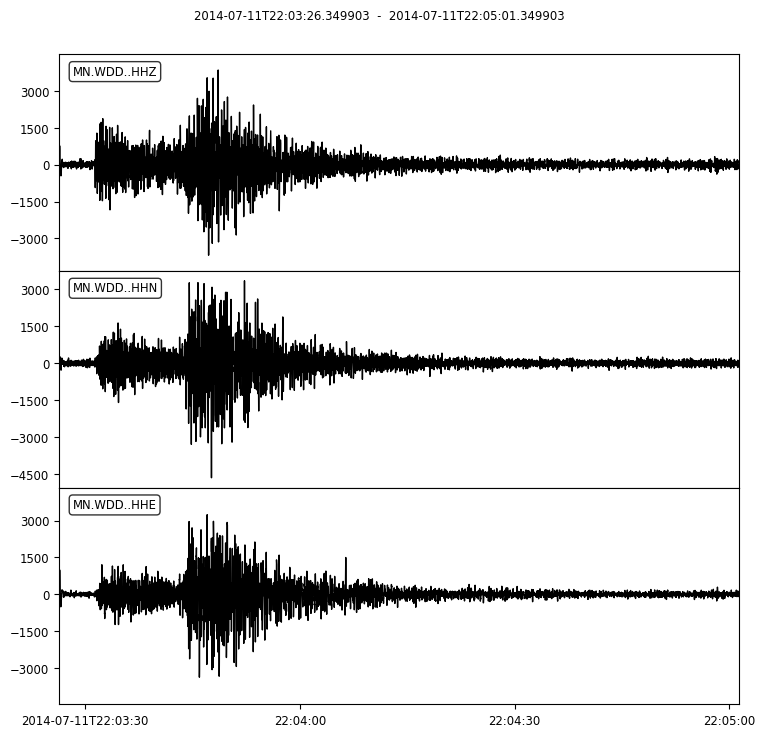

In [222]:
plot_filter(2014, 192, '2014-07-11 22:03:31.350')


A Quality


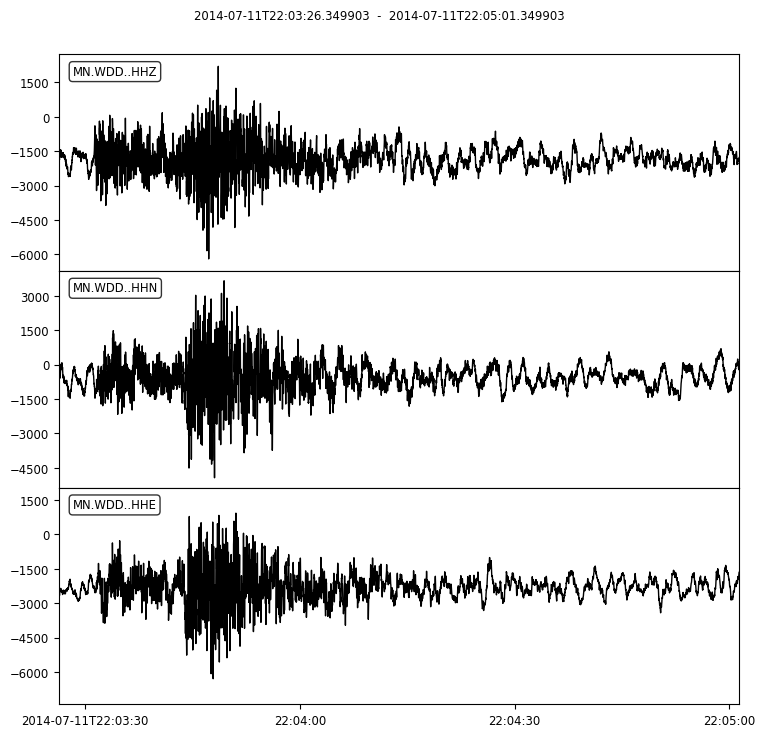

In [168]:
print('A Quality')
plot(2014, 192, '2014-07-11 22:03:31.350')


B Quality


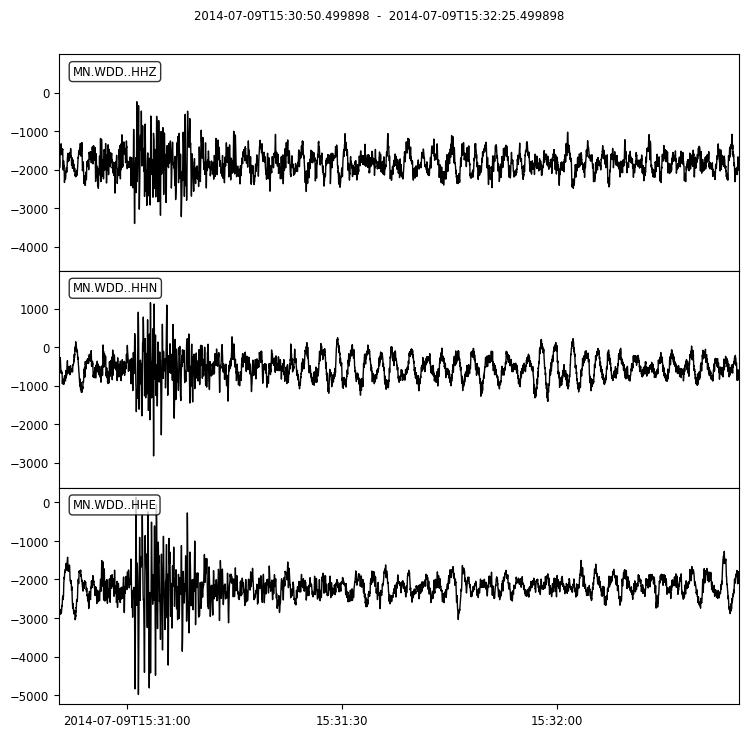

In [223]:
print('B Quality')
event = events.iloc[11]
plot(event['year'], event['day'], event['date']+event['pTime'])

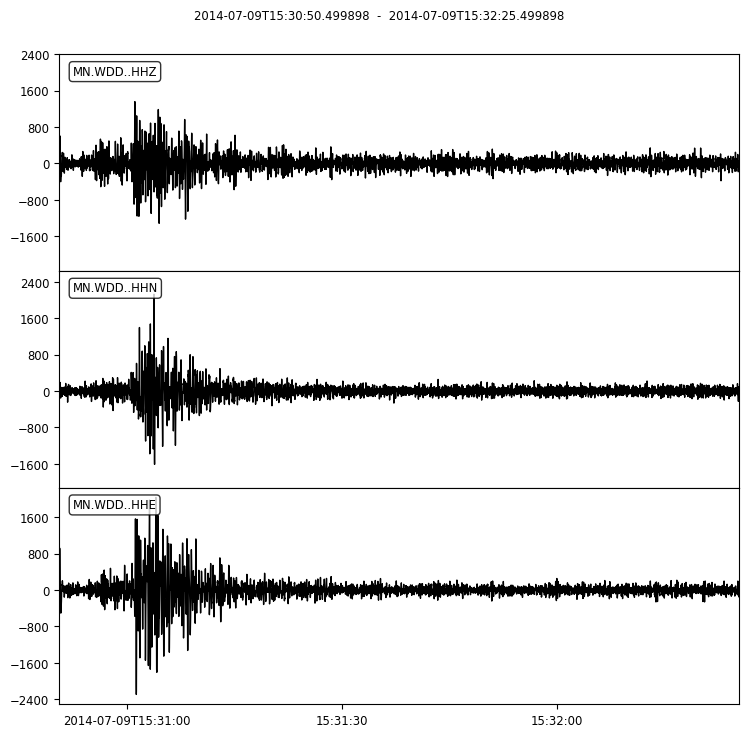

In [224]:
plot_filter(event['year'], event['day'], event['date']+event['pTime'])


C Quality


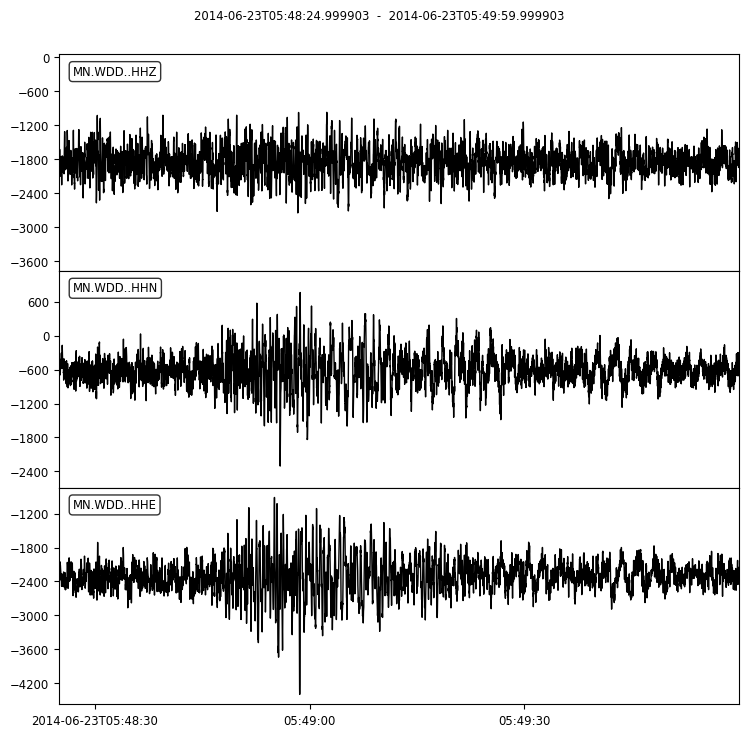

In [226]:
print('C Quality')
event = events.iloc[15]
plot(event['year'], event['day'], event['date']+event['pTime'])


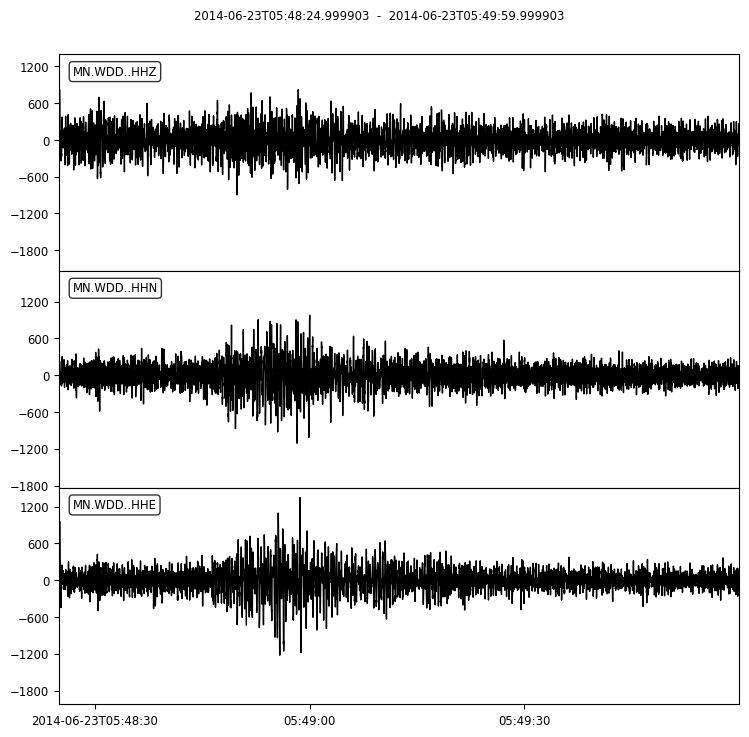

In [227]:
plot_filter(event['year'], event['day'], event['date']+event['pTime'])
